In [20]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import random

import cv2
from skimage import io
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage.color import rgb2gray
from tqdm import tqdm

from skimage import io, transform, morphology, filters
from scipy import ndimage

%matplotlib inline 

TRAIN_PATH = '../data/stage1_train/'
TEST_PATH = '../data/stage1_test/'

In [14]:
# Utility function for plotting multiple images
def plots(imgs, figsize=(12,6), rows=1, title=None, titles=None):
    f = plt.figure(figsize=figsize)
    if title is not None: plt.title(title)
    for i in range(len(imgs)):
        sp = f.add_subplot(rows, len(imgs)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=8)
        plt.imshow(np.squeeze(imgs[i]), cmap='gray')

In [6]:
# Reading and pre-processing mainly based on:
# https://www.kaggle.com/raoulma/nuclei-dsb-2018-tensorflow-u-net-score-0-352
def read_image(filepath, color_mode=cv2.IMREAD_COLOR, target_size=None):
    """Read an image from a file and resize it."""
    img = cv2.imread(filepath, color_mode)
    if target_size: 
        img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    return img

def read_mask(directory, target_size=None):
    """Read and resize masks contained in a given directory."""
    for i,filename in enumerate(next(os.walk(directory))[2]):
        mask_path = os.path.join(directory, filename)
        mask_tmp = read_image(mask_path, cv2.IMREAD_GRAYSCALE, target_size)
        if not i: mask = mask_tmp
        else: mask = np.maximum(mask, mask_tmp)
    return mask

def load_raw_data(image_size=(256, 256)):
    save_name = '../data/dataset_{}x{}'.format(image_size[0],image_size[1])
    save_path = save_name + '.npz'
    
    if os.path.isfile(save_path):
        print('Reading from previously loaded data.')
        npzfile = np.load(save_path)
        return npzfile['X_train'], npzfile['Y_train'], npzfile['X_test']
    
    train_ids = next(os.walk(TRAIN_PATH))[1]
    test_ids = next(os.walk(TEST_PATH))[1]
    
    print('Getting and resizing train images and masks ... ')
    # TODO do we need dtype for these images?
    X_train = np.zeros((len(train_ids), image_size[0], image_size[1], 3), dtype=np.uint8)
    Y_train = np.zeros((len(train_ids), image_size[1], image_size[1]))
    sys.stdout.flush()
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        path = TRAIN_PATH + id_
        img = read_image(path + '/images/' + id_ + '.png', target_size=image_size)
        mask = read_mask(path + '/masks/', target_size=image_size)
        X_train[n] = img
        Y_train[n] = mask

    Y_train = np.expand_dims(Y_train, axis=4)
        
    print('Getting and resizing test images ... ')
    sys.stdout.flush()
    X_test = np.zeros((len(test_ids), image_size[0], image_size[1], 3), dtype=np.uint8)
    for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
        path = TEST_PATH + id_
        img = read_image(path + '/images/' + id_ + '.png', target_size=image_size)
        X_test[n] = img

    print('Saving to npz...')
    np.savez_compressed(save_name, X_train=X_train, Y_train=Y_train, X_test=X_test)
    print('Done!')
    return X_train, Y_train, X_test

In [7]:
IMG_HEIGHT = 256
IMG_WIDTH = 256

X_train, Y_train, X_test = load_raw_data(image_size=(IMG_HEIGHT, IMG_WIDTH))

Reading from previously loaded data.


In [ ]:
idx = random.randint(1, X_train.shape[0])
plots([X_train[idx], Y_train[idx]])

### Try weight calculation

From: https://www.kaggle.com/piotrczapla/tensorflow-u-net-starter-lb-0-34

In [16]:
def read_mask_with_individuals(directory, target_size=None):
    """Read and resize masks contained in a given directory."""
    masks = []
    for i,filename in enumerate(next(os.walk(directory))[2]):
        mask_path = os.path.join(directory, filename)
        mask_tmp = read_image(mask_path, cv2.IMREAD_GRAYSCALE, target_size)
        masks.append(mask_tmp)
        if i==0: 
            merged_mask = mask_tmp
        else: 
            merged_mask = np.maximum(merged_mask, mask_tmp)
    return merged_mask, masks

In [25]:
train_ids = next(os.walk(TRAIN_PATH))[1]
image_size = (256, 256)
# for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
id_ = train_ids[1]
path = TRAIN_PATH + id_
img = read_image(path + '/images/' + id_ + '.png', target_size=image_size)
merged_mask, masks = read_mask_with_individuals(path + '/masks/', target_size=image_size)

In [26]:
def calculate_unet_background_weight(merged_mask, masks, w0=10, q=5,):
    weight = np.zeros(merged_mask.shape)
    # calculate weight for important pixels
    distances = np.array([ndimage.distance_transform_edt(m==0) for m in masks])
    shortest_dist = np.sort(distances, axis=0)
    # distance to the border of the nearest cell 
    d1 = shortest_dist[0]
    # distance to the border of the second nearest cell
    d2 = shortest_dist[1] if len(shortest_dist) > 1 else np.zeros(d1.shape)

    weight = w0 * np.exp(-(d1+d2)**2/(2*q**2)).astype(np.float32)
    weight = 1 + (merged_mask == 0) * weight
    return weight

def binary_erosion_tf(mask):
    def binary_erosion(img):
        img = ndimage.morphology.binary_erosion((img > 0 ), border_value=1).astype(np.uint8)
        return img
    return tf.py_func(binary_erosion, [mask], tf.uint8)

def calculate_weights_tf(merged_mask, masks):
    return tf.py_func(calculate_unet_background_weight, [merged_mask, masks], tf.float32)

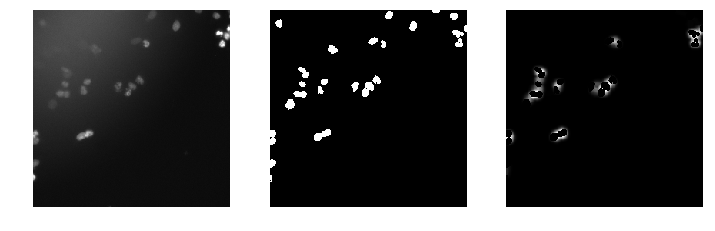

In [27]:
weight = calculate_unet_background_weight(merged_mask, masks)
plots([img, merged_mask, weight])

In [ ]:
def preprocess_raw_data(x_train, y_train, x_test, grayscale=False, invert=False):
    pass